# Bank Note Authentication

### Aim
> Detect forged banknotes based on data (extracted from images) from genuine and forged banknote-like specimens.

In [56]:
import numpy as np 
import pandas as pd
import csv
import os
from numpy import mean, std
for dirname, _, filenames in os.walk(r'C:\Users\MahaShruthi\OneDrive\Documents\Excel\BankNoteAuthentication.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
pd.options.display.max_colwidth = 200
warnings.filterwarnings(action='ignore')

In [3]:
# plotting lib
import matplotlib.pyplot as plt
import seaborn as sns

In [186]:
from sklearn.model_selection import train_test_split,cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from functools import partial
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, accuracy_score

In [188]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [6]:
df=pd.read_csv(r'C:\Users\MahaShruthi\OneDrive\Documents\Excel\BankNoteAuthentication.csv')

>- “feature”: filtered column 0 to column 3 that contain our feature set
>- “label”: filtered records from column 4 which contains the labels (class)

In [7]:
numerical_features = ['variance','skewness','curtosis','entropy']

In [8]:
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


> ##### Information about the dataset
>- Variance: Variance of Wavelet Transformed image (WTI) (continuous)
>- Skewness: Skewness of WTI (continuous)
>- Curtosis: Curtosis of WTI (continuous)
>- Entropy: Entropy of image (continuous)
>- Class: Whether or not the banknote was authentic (integer)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [10]:
#the shape of the dataset
print("(",df.count(),",",len(df.columns),")")

( variance    1372
skewness    1372
curtosis    1372
entropy     1372
class       1372
dtype: int64 , 5 )


In [11]:
df[df.duplicated()].shape[0]

24

In [12]:
# Dropping all the duplicate values
df.drop_duplicates(subset=None, keep='first', inplace=True)

In [13]:
df.isnull().sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

<AxesSubplot:>

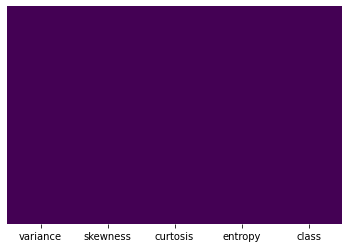

In [14]:
# Checking the null values
sns.heatmap(df.isnull(),yticklabels = False,cbar = False,cmap = 'viridis')

> There is no missing values in the dataset.

In [15]:
# Detecting the ouliers
def detect_outlier(data):
    outlier = []
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    for i in data:
        z_score = (i - mean)/std
        if np.abs(z_score)>threshold:
            outlier.append(i)
    return outlier

In [16]:
var_list = df['variance'].tolist()
skew_list = df['skewness'].tolist()
curt_list = df['curtosis'].tolist()
entr_list = df['entropy'].tolist()

In [17]:
var_outlier = detect_outlier(var_list)
var_outlier

[]

In [18]:
skew_outlier = detect_outlier(skew_list)
skew_outlier

[]

In [19]:
curt_outlier = detect_outlier(curt_list)
curt_outlier

[15.6824,
 17.6772,
 14.9704,
 17.3087,
 15.5573,
 17.9274,
 16.9583,
 14.8881,
 17.5795,
 15.6773,
 17.6052,
 15.6199,
 17.1116,
 15.6559,
 17.0834,
 15.4417,
 16.7166,
 15.1606,
 17.5932]

In [20]:
entr_outlier = detect_outlier(entr_list)
entr_outlier

[-7.5034,
 -7.5836,
 -7.5034,
 -7.7853,
 -7.7581,
 -8.5482,
 -7.5487,
 -7.6418,
 -7.8719,
 -7.6612,
 -7.5034,
 -7.5344,
 -7.5887,
 -7.5642,
 -7.5887]

In [21]:
# Removing the outliers
df.drop(df[df['curtosis'] >= 14.8881].index, inplace = True)
df.drop(df[df['entropy'] <= -7.5034].index, inplace = True)

In [22]:
#Shape of Data after removing the outliers
print("Shape of Data after outliers: {}".format(df.shape))

Shape of Data after outliers: (1314, 5)


          variance     skewness     curtosis      entropy        class
count  1314.000000  1314.000000  1314.000000  1314.000000  1314.000000
mean      0.551997     2.030672     1.213835    -1.083402     0.445967
std       2.811866     5.588816     3.981034     1.987055     0.497261
min      -7.042100   -13.286900    -5.286100    -7.398700     0.000000
25%      -1.690700    -1.375525    -1.646875    -2.204625     0.000000
50%       0.594025     2.372450     0.550230    -0.544620     0.000000
75%       2.947950     6.686375     3.073200     0.419380     1.000000
max       6.824800    12.951600    14.368900     2.449500     1.000000


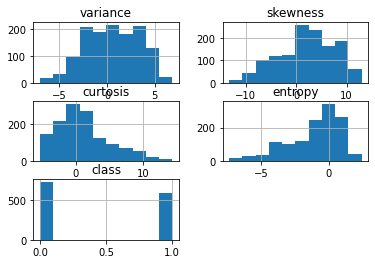

In [23]:
# show summary statistics
print(df.describe())
# plot histograms
df.hist()
plt.show()

>- Values vary with different means and standard deviations
>- First two variables have a Gaussian-like distribution and the next two input variables may have a skewed Gaussian distribution or an exponential distribution. 

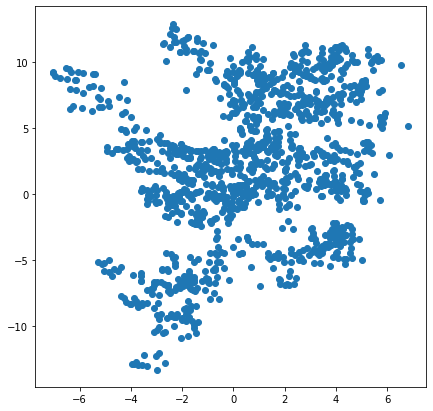

In [24]:
plt.figure(figsize = [7, 7])
plt.scatter(df.variance, df.skewness);

>**Inference:**
>- The data distribution in the graph is not too widespread, neither too centered at one place, therefore it is worth trying to computing K-Means on this dataset.
>- There is no obvious cluster in spherical shapes so we should expect the K-Means model won't work perfectly here.

In [25]:
# check the number of features for each class in the training set
pd.value_counts(df['class'], sort=True)

0    728
1    586
Name: class, dtype: int64

Text(0.5, 1.0, 'class (Forged VS Genuine)')

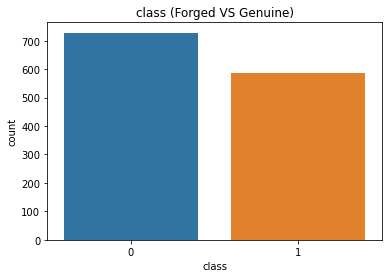

In [26]:
sns.countplot(x=df["class"])
plt.title('class (Forged VS Genuine)')

> Both the classes have nearly equal count. Hence, the dataset has good balance

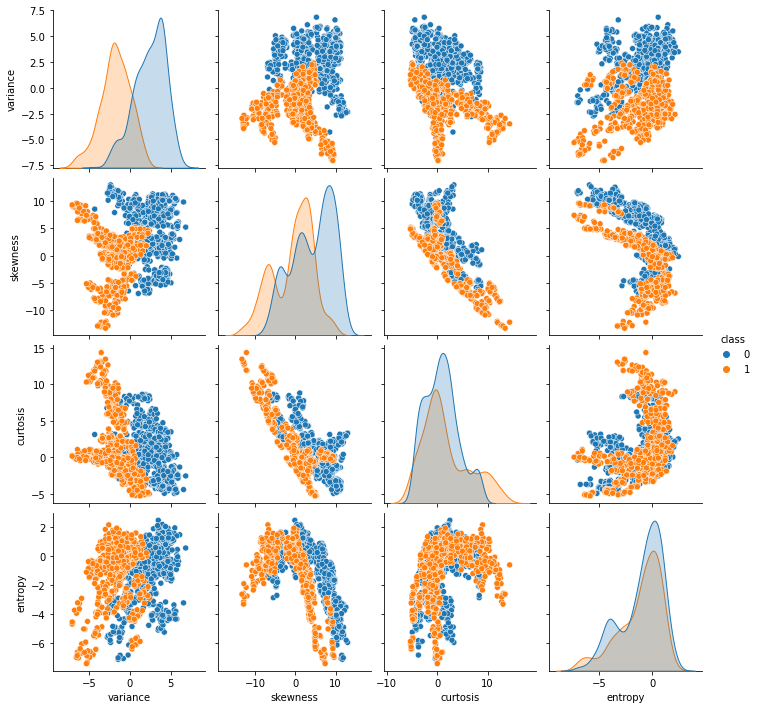

In [27]:
sns.pairplot(df, hue="class")

>- Curtoisis and skewness are negatively correlated ;
>- From Variance distribution plot, we can see that it is very discriminative. It might be might be the most influential variable.

In [28]:
#plots analysing numerical features
def plot_numeric(data, numeric_features, target) :  
    # Looping through and Plotting Numeric features
    for column in numeric_features:    
        
        fig = plt.figure(figsize=(18,12))

        ### Distribution plot
        sns.distplot(df[column], ax=plt.subplot(221));
        plt.xlabel(column, fontsize=14);
        plt.ylabel('Density', fontsize=14);
        plt.suptitle('Plots for '+column, fontsize=18);

        ### Distribution per Positive / Negative class Value
        classes = df[target].unique()
        sns.distplot(df.loc[df[target]==classes[0], column].dropna(),
                     color='red', label=str(classes[0]), ax=plt.subplot(222));
        # Survived hist
        sns.distplot(df.loc[df[target]==classes[1], column].dropna(),
                     color='blue', label=str(classes[1]), ax=plt.subplot(222));
        plt.legend(loc='best')
        plt.xlabel(column, fontsize=14);
        plt.ylabel('Density per '+ str(classes[0])+' / '+str(classes[1]), fontsize=14);

        ### Average Column value per positive / Negative Value
        sns.barplot(x=target, y=column, data=df, ax=plt.subplot(223));
        plt.xlabel('Positive or Negative?', fontsize=14);
        plt.ylabel('Average ' + column, fontsize=14);

        ### Boxplot of Column per Positive / Negative class Value
        sns.boxplot(x=target, y=column, data=df, ax=plt.subplot(224));
        plt.xlabel('Positive or Negative ?', fontsize=14);
        plt.ylabel(column, fontsize=14);
        plt.show()

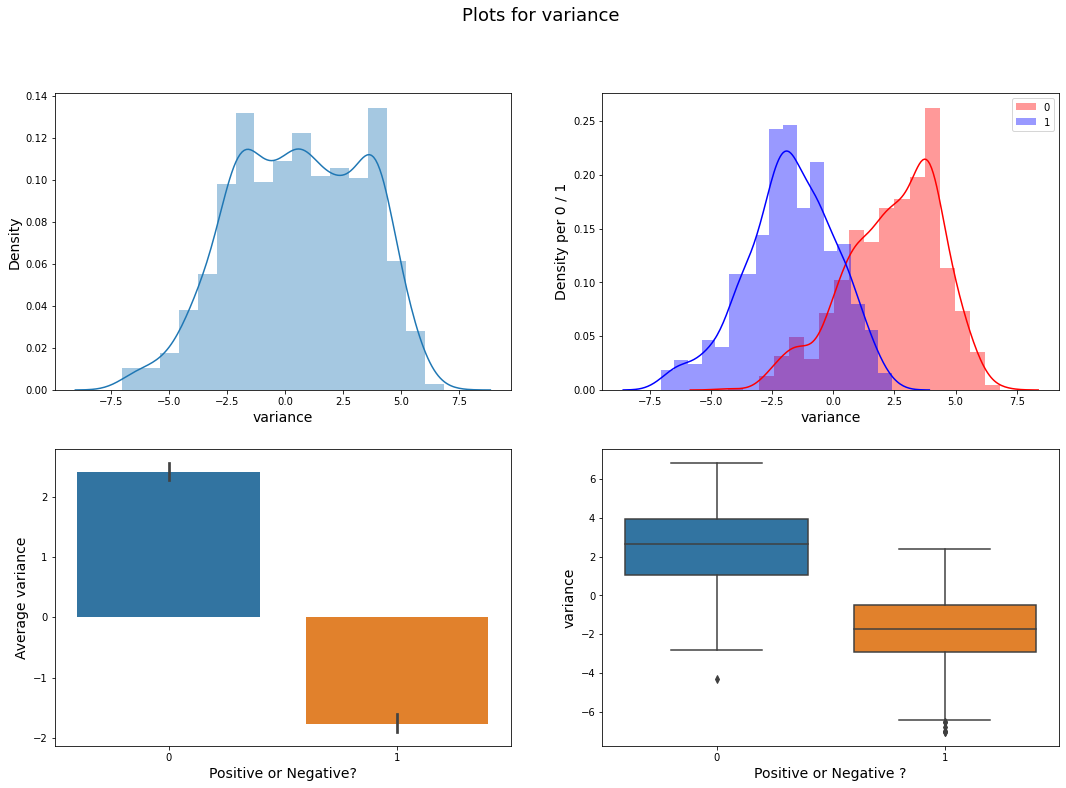

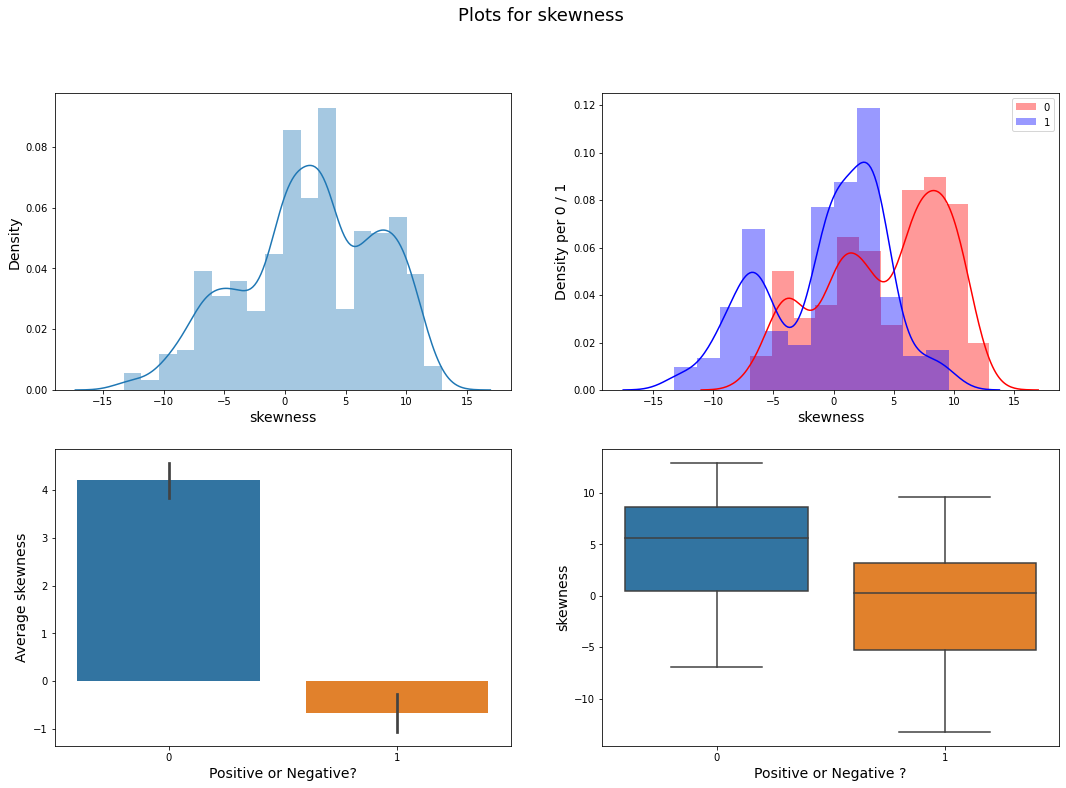

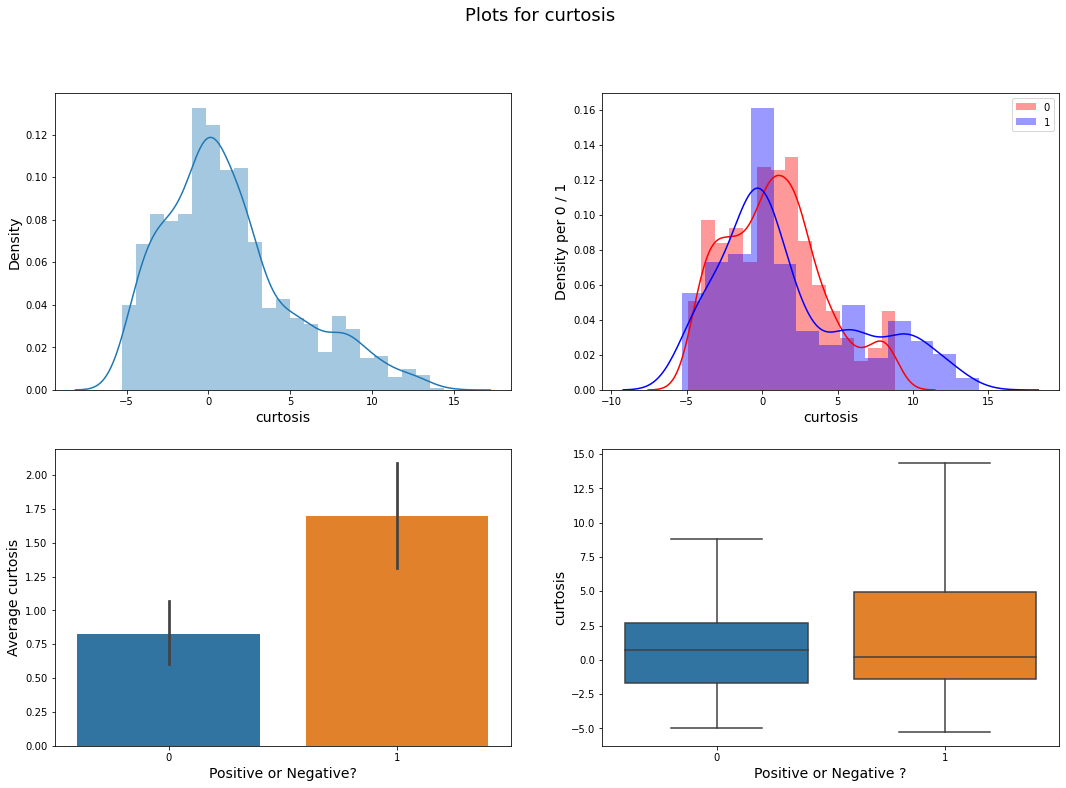

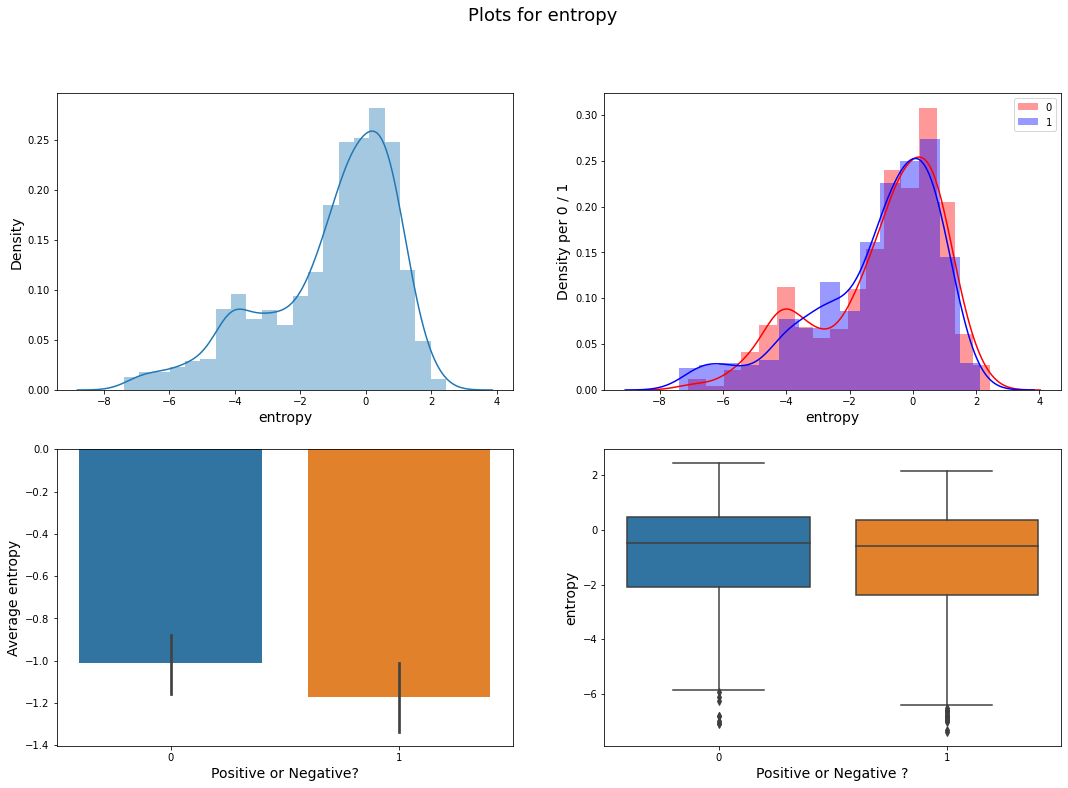

In [29]:
### Plotting Numeric Features
plot_numeric(df, numerical_features, 'class')

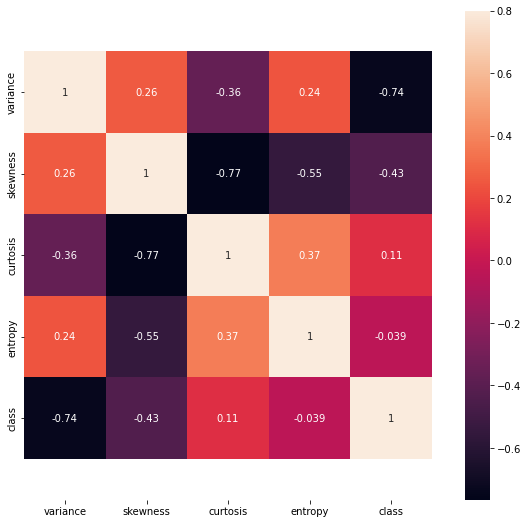

In [30]:
def correlationMap(df, target) :
    classes = df[target].unique()
    if df[target].dtype == 'O' :
        df[target+'_id'] = (df[target]== classes[0]).astype(int) #encode string target 
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(corr, vmax=.8,annot=True, square=True)
    if df[target].dtype == 'O' :
        df.drop([target+'_id'], axis=1, inplace=True)
    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5
    plt.ylim(b, t)
    plt.show()
correlationMap(df,'class')

>- Variables "skewness" and "curtoisis" are negatively correlated. 
>- Variance is stongly correlated with classification in comparison with other variables.

In [31]:
# Split it to train and test
train_data, test_data = train_test_split(df) 

In [32]:
def featureEng(numerical_features, categorical_features):
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    t =  ColumnTransformer([('Scaler', numeric_transformer, numerical_features),('OneHotEncod', categorical_transformer, categorical_features)])
    preproc = Pipeline(steps=[('preprocessor', t)])
    return preproc

In [33]:
# Encoding categorical features
transf_train = featureEng(numerical_features, categorical_features=[]).fit(train_data)
X_train = transf_train.transform(train_data)
y_train = train_data['class'].values

In [34]:
#  get columns names after transformations
X_train.shape

(985, 4)

In [35]:
# PCA on numerical features

pca = PCA(n_components=X_train.shape[1])
principalComponents = pca.fit_transform(X_train[:,:len(numerical_features)])
principalDf = pd.DataFrame(data = principalComponents[:,:2]
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame(y_train)], axis = 1)

In [36]:
pca.explained_variance_

array([2.21489764, 1.24846038, 0.33817929, 0.20252773])

In [37]:
pca.explained_variance_ratio_

array([0.55316225, 0.31179823, 0.08445899, 0.05058053])

>The two PCs verifies Kaiser rule.

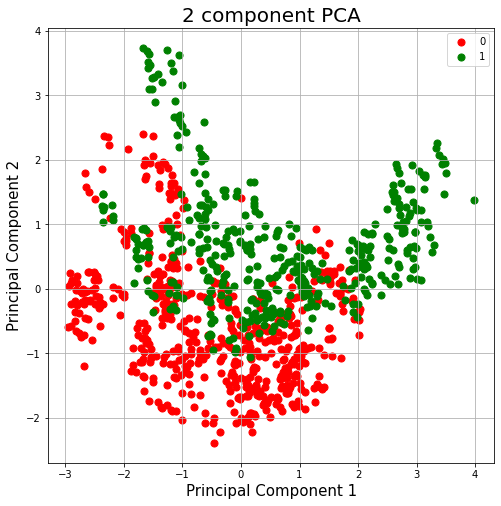

In [38]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf[0] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

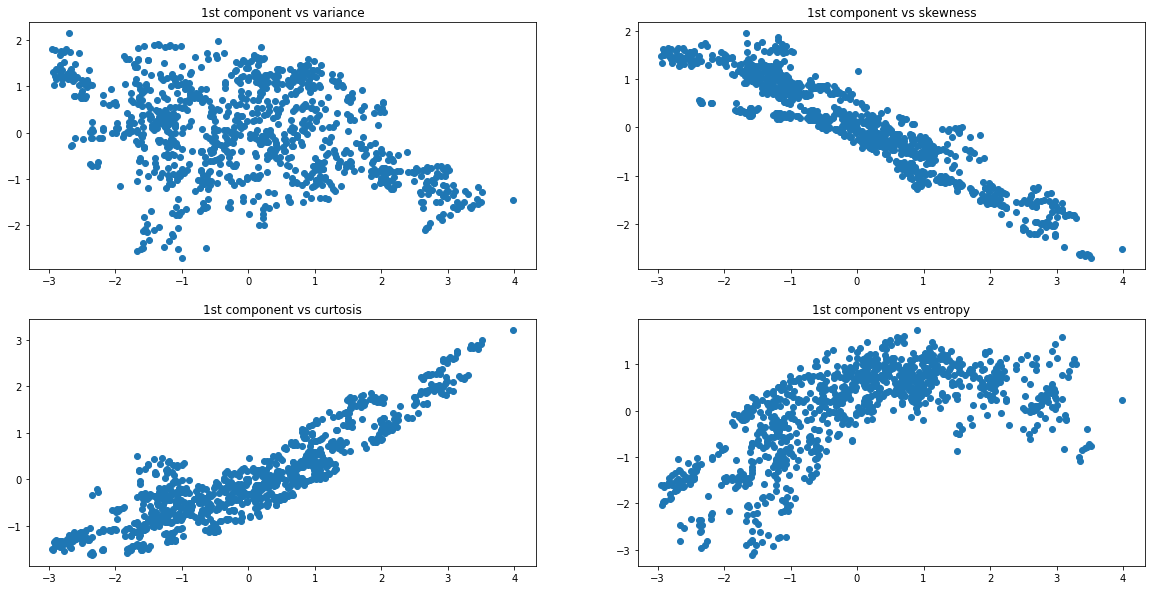

In [39]:
# First Component
n_axes = len(numerical_features)
_, axes = plt.subplots(ncols=2,nrows=2, figsize=(20,10))
col_id = 0

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        try :
            axes[i][j].scatter(principalComponents[:,0], X_train[:,col_id])
            axes[i][j].set_title(f'1st component vs {numerical_features[col_id]}')
            col_id = col_id+1
        except exception as e:
            print(e)
            break

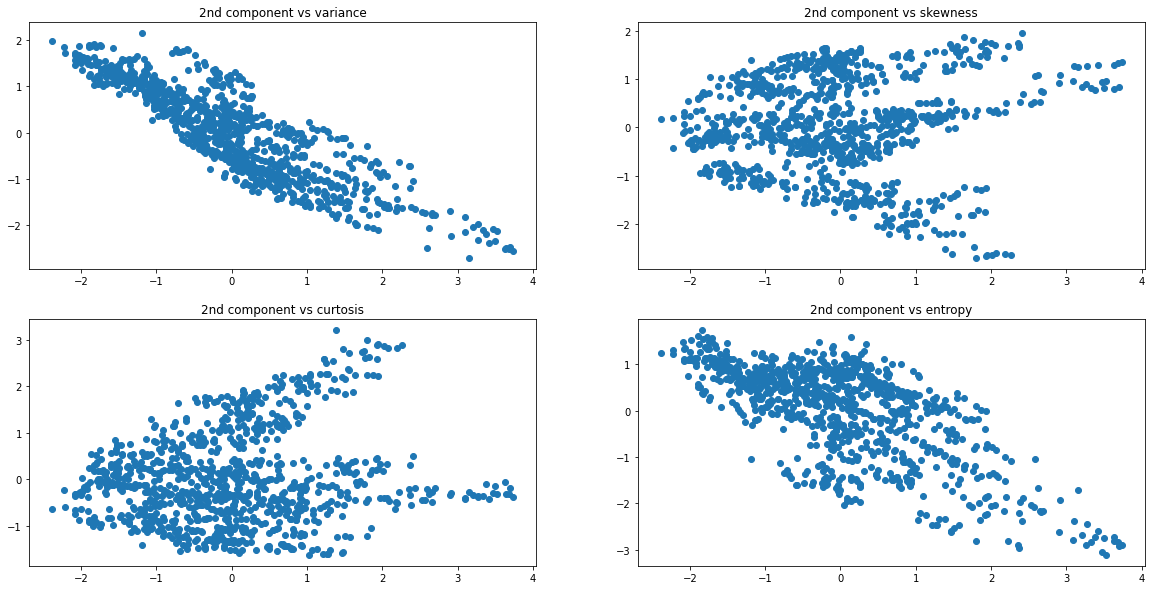

In [40]:
# Second component
n_axes = len(numerical_features)
_, axes = plt.subplots(ncols=2,nrows=2, figsize=(20,10))
col_id = 0

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        try :
            axes[i][j].scatter(principalComponents[:,1], X_train[:,col_id])
            axes[i][j].set_title(f'2nd component vs {numerical_features[col_id]}')
            col_id = col_id+1
        except exception as e:
            print(e)
            break

>+ Skewness and Curtoisis are correlated with PC1 
>+ Variance and entropy are correlated with the PC2.

In [41]:
#FEATURE SELECTION

class selectFeaturesTransformer(BaseEstimator, TransformerMixin):
    """Custom scaling transformer"""
    def __init__(self, k=10,method='RF',discreteCol=[]):
        """ 
        initialize transformer
        Inputs : 
            k -- number of features to keep
            method -- method to use, either 'Mutual Information or RF
            discreteCol -- if Mutual Information is used, specify indexes of discrete columns
        """
        self.k = k
        self.method = method
        self.order = []
        self.discreteCol = discreteCol
        
        
        

    def fit(self, X_train,y_train):
        """
        Fit the transformer on data
        Input :
            X_train -- features array
            Y_train -- labels array
        Output :
            fitted transformer
        """
        if self.method == "Mutual Information" :
            discrete_mutual_info_classif = partial(mutual_info_classif, 
                                                   discrete_features=self.discreteCol)
            featS = SelectKBest(k=self.k, score_func=discrete_mutual_info_classif).fit(X_train,y_train )
            self.order = np.flip(featS.scores_.argsort())
            #self.selectedColumns = [columns_eng[i]  for i in self.order[:self.k]]
            #return X_train[:,order_mi[:self.k]]
        
        else :
            rfModel = RandomForestClassifier(random_state =0).fit(X_train, y_train)
            order = np.flip(rfModel.feature_importances_.argsort())
            self.order = np.flip(rfModel.feature_importances_.argsort())
            #self.selectedColumns = [columns_eng[i]  for i in order_rf[:self.k]]
            #return X_train[:,order_[:self.k]]
        return self
                
                
        
    def transform(self, X_train):
        """
        apply fitted transformer to select features
        Input :
            X_train -- features array
        Output :
            array containing only selected features
        """
        return X_train[:,self.order[:self.k]]

In [42]:
discreteCol = []

FSelector_mi = selectFeaturesTransformer(k=4,method="Mutual Information", discreteCol=False)
FSelector_rf = selectFeaturesTransformer(k=4,method="Random Forest")
FSelector_mi.fit(X_train,y_train)
FSelector_rf.fit(X_train,y_train)

selectFeaturesTransformer(k=4, method='Random Forest')

In [43]:
print("Features ordered by importance selected by Mutual information")
print([numerical_features[i]  for i in FSelector_mi.order[:10]])
print("\nFeatures ordered by importance selected by Random Forest")
print([numerical_features[i]  for i in FSelector_rf.order[:10]])

Features ordered by importance selected by Mutual information
['variance', 'skewness', 'curtosis', 'entropy']

Features ordered by importance selected by Random Forest
['variance', 'skewness', 'curtosis', 'entropy']


> Both method find the same order, with variance at the top. This confirms our previous remarks.

In [44]:
# split into input and output columns
X, y = df.values[:, :-1], df.values[:, -1]

In [64]:
# encode strings to integer
le = LabelEncoder()
y = le.fit_transform(y)

In [45]:
# Encoding categorical features
transf_test = featureEng(numerical_features, categorical_features=[]).fit(test_data)
X_test = transf_train.transform(test_data)
y_test = test_data['class'].values

In [192]:
# FUNCTION FOR CONFUSION MATRICS
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Naive Bayes Classifier

#### MODEL TRAINING

Results for model GaussianNB
Correct: 105
Incorrect: 26
Accuracy: 80.152672%
Confusion matrix, without normalization
[[  0   0]
 [ 26 105]]


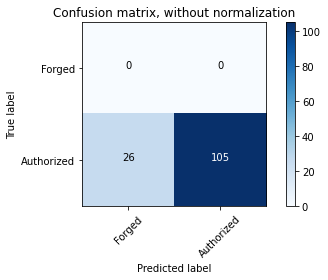

In [193]:
## Naive Bayes Classifier
nbc=GaussianNB()
nbc.fit(X_train,y_train)
y_pred6=nbc.predict(X_test)
correct = 0
incorrect = 0
total = 0
for actual, predicted in zip(y_test, y_pred6):
    total += 1
    if actual == predicted:
        correct += 1
    else:
        incorrect += 1
a=100 * correct / total
# Print results
print(f"Results for model {type(nbc).__name__}")
print(f"Correct: {correct}")
print(f"Incorrect: {incorrect}")
print(f"Accuracy: {a:3f}%")
acc = []
acc.append(a)
cnf_matrix = confusion_matrix(y_test, y_pred6)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Forged','Authorized'],
                      title='Confusion matrix, without normalization')

## Decision Tree

#### MODEL TRAINING

Results for model DecisionTreeClassifier
Correct: 128
Incorrect: 3
Accuracy: 97.709924%
Confusion matrix, without normalization
[[  0   0]
 [  3 128]]


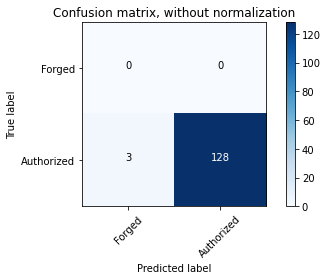

In [197]:
from sklearn.tree import DecisionTreeClassifier
dtc=DecisionTreeClassifier(max_depth=10, random_state=101, max_features=None, min_samples_leaf=15)
dtc.fit(X_train,y_train)
y_pred4=dtc.predict(X_test)
correct = 0
incorrect = 0
total = 0
for actual, predicted in zip(y_test, y_pred4):
    total += 1
    if actual == predicted:
        correct += 1
    else:
        incorrect += 1
a=100 * correct / total
# Print results
print(f"Results for model {type(dtc).__name__}")
print(f"Correct: {correct}")
print(f"Incorrect: {incorrect}")
print(f"Accuracy: {a:3f}%")
acc.append(a)
cnf_matrix = confusion_matrix(y_test, y_pred4)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Forged','Authorized'],
                      title='Confusion matrix, without normalization')

## Multilayer Perceptron (MLP) model

#### MODEL TRAINING

In [46]:
# determine the number of input features
n_features = X.shape[1]
# define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', 
                input_shape=(n_features,)))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')

>- fitting the model for 50 training epochs (chosen arbitrarily) with a batch size of 32 

In [47]:
# fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, 
                    validation_data=(X_test,y_test))

#### MODEL COMPARISON

In [199]:
# Model
models = []
models.append(('NBC'))
models.append(('DT'))
models.append(('MLP'))

In [201]:
acc

[80.1526717557252, 97.70992366412214, 97.70992366412214, 1.0]

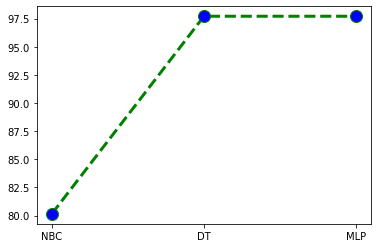

In [200]:
import matplotlib.pyplot as plt
graph=plt.plot(models, acc, color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
graph

#### MODEL TESTING

In [ ]:
# predict test set and convert to class label
ypred = model.predict(X_test)
yhat = (ypred > 0.5).flatten().astype(int)
# evaluate predictions
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)

Accuracy: 0.988


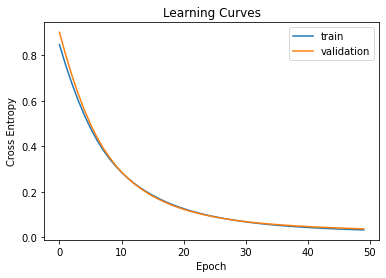

In [ ]:
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

>- The model appears to converge well and does not show any signs of overfitting or underfitting.

#### Robust Model Evaluation

In [181]:
# prepare cross validation
kfold = KFold(10)
# enumerate splits
scores = list()
for train_ix, test_ix in kfold.split(X, y):
    # fit and evaluate the model
    # split data
    X_train, X_test, y_train, y_test = X[train_ix], X[test_ix], y[train_ix], y[test_ix]
    # determine the number of input features
    n_features = X.shape[1]
    # define model
    model = Sequential()
    model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy')
    # fit the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    # predict test set and convert to class label
    ypred = model.predict(X_test)
    yhat = (ypred > 0.5).flatten().astype(int) 
    # evaluate predictions
    score = accuracy_score(y_test, yhat)
    print('> %.3f' % score)
    scores.append(score)
# summarize all scores
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
acc.append(mean(scores))

> 0.985
> 1.000
> 1.000
> 1.000
> 0.985
> 1.000
> 1.000
> 1.000
> 1.000
> 1.000
Mean Accuracy: 0.997 (0.006)


> Reports the model performance for each iteration of the evaluation procedure and the mean and standard deviation of classification accuracy at the end of the run.

**RESULT**
>- **MLP model achieved a mean accuracy of about 99.8 %**
>- **The model is a good fit for the problem since it matches with the base model**

#### PREDICTIONS

##### Demo 1

In [168]:
# define a row of new data
row = [3.6216,8.6661,-2.8073,-0.44699]

In [169]:
# make prediction and convert to class label
ypred = model.predict([row])
yhat = (ypred > 0.5).flatten().astype(int)
# invert transform to get label for class
yhat = le.inverse_transform(yhat)

In [170]:
# report prediction
def report(result):
    if result == 0.0:
        print('\033[1m''Predicted class:\033[1;32m %s' % (yhat[0]))
        print('The currency is GENUINE''\033[1m')
    else:
        print('\033[1m'+'Predicted class:\033[1;31m %s' % (yhat[0]))
        print('The currency is FORGED'+'\033[1m')

In [171]:
result = yhat[0]
report(result)

Predicted class: 0.0
The currency is GENUINE


##### Demo 2

In [172]:
# define a row of new data
row1 = [-3.6106, 6.6861, -0.073, -6.54699]

In [173]:
# make prediction and convert to class label
ypred = model.predict([row1])
yhat = (ypred > 0.5).flatten().astype(int)
# invert transform to get label for class
yhat = le.inverse_transform(yhat)

In [174]:
result = yhat[0]
report(result)

Predicted class: 1.0
The currency is FORGED
